#### NOTE: - The dataset was downloaded in COCO format

### Imports

In [2]:
import json
import torch
import os
from PIL import Image
from tqdm.autonotebook import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms as T

C:\Users\pratyush\AppData\Local\Temp\ipykernel_7020\2452924149.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


### Analyzing the coco annotations

In [3]:
with open('train\_annotations.coco.json','r') as f:
    x = json.load(f)

In [4]:
x.keys()

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

In [5]:
x['info'],x['licenses']

({'year': '2024',
  'version': '3',
  'description': 'Exported from roboflow.com',
  'contributor': '',
  'url': 'https://public.roboflow.com/object-detection/undefined',
  'date_created': '2024-06-07T20:21:02+00:00'},
 [{'id': 1,
   'url': 'https://creativecommons.org/licenses/by/4.0/',
   'name': 'CC BY 4.0'}])

In [6]:
x['categories']

[{'id': 0, 'name': 'wall-urlW', 'supercategory': 'none'},
 {'id': 1, 'name': 'Rough Wall', 'supercategory': 'wall-urlW'},
 {'id': 2, 'name': 'Smooth Wall', 'supercategory': 'wall-urlW'}]

### Custom Dataloader

In [8]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,root_dir):
        with open(os.path.join(root_dir,'_annotations.coco.json')) as f:
            data = json.load(f)
        self.root_dir = root_dir
        self.image_id_to_info = {img['id']: img for img in data['images']}

        self.image_id_to_anns = {}
        for ann in data['annotations']:
            self.image_id_to_anns.setdefault(ann['image_id'],[]).append(ann)
        self.image_ids = list(self.image_id_to_info.keys())

    def __len__(self):
            return len(self.image_ids)
        
    def __getitem__(self,idx):
            image_id = self.image_ids[idx]
            image_info = self.image_id_to_info[image_id]
            anns = self.image_id_to_anns.get(image_id,[])

            if len(anns) == 0:
                return None

            image_path = os.path.join(self.root_dir,image_info['file_name'])
            image = Image.open(image_path).convert('RGB')

            boxes = []
            labels = []

            for ann in anns:
                x,y,w,h = ann['bbox']
                boxes.append([x,y,x+w,y+h])
                labels.append(ann['category_id'])
            
            boxes = torch.tensor(boxes,dtype=torch.float32)
            labels = torch.tensor(labels,dtype=torch.int64)

            target = {
                'boxes':boxes,
                'labels':labels,
                'image_id':torch.tensor([image_id])
            }
            return image,target

In [9]:
train_dataset = Dataset(root_dir='train')
val_dataset = Dataset(root_dir='valid')
test_dataset = Dataset(root_dir='test')
def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    return tuple(zip(*batch))

train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=8,shuffle=True,collate_fn=collate_fn)
val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=8,shuffle=False,collate_fn=collate_fn)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=8,shuffle=False,collate_fn=collate_fn)

In [1]:
# This is the custom defined metric
def wall_surface_smoothness_score(crop):
    """
    This function estimates how visually smooth a wall surface appears using:
    1. Gradient Magnitude (Sobel) - Measures overall intensity variation.
    2. Laplacian Variance - Measures sharpness/blurriness.
    3. Canny Edge Count - Detects and counts prominent edges in the surface.

    Smooth surfaces will have:
    - Low gradient magnitude (less texture)
    - Low Laplacian variance (less fine structure)
    - Fewer Canny edges (minimal edge-like features)

    """
    gray = cv2.cvtColor(crop, cv2.COLOR_RGB2GRAY)
    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    grad_mag = np.sqrt(grad_x**2 + grad_y**2)
    grad_mean = np.mean(grad_mag)

    lap = cv2.Laplacian(gray, cv2.CV_64F)
    lap_var = np.var(lap)

    canny_edges = cv2.Canny(gray, 50, 150)
    canny_edge_count = np.sum(canny_edges > 0)

    grad_score = 1.0 - np.tanh(grad_mean / 10)
    lap_score= 1.0 - np.tanh(lap_var / 10)
    canny_score = 1.0 - np.tanh(canny_edge_count / (gray.shape[0] * gray.shape[1] / 4))
    smoothness_score = (grad_score + lap_score + canny_score) / 3.0

    
    return round(smoothness_score,3) , grad_mag, lap , canny_edges

def process_and_plot_regions(pil_img, target):
    img_rgb = pil_img.convert("RGB")
    img_np = np.array(img_rgb)

    for i, box in enumerate(target['boxes']):
        x1, y1, x2, y2 = map(int, box.tolist())
        crop = img_np[y1:y2, x1:x2]
        if crop.size == 0:
            continue

        score, grad_mag, lap, canny_edges = wall_surface_smoothness_score(crop)
        label = "Smooth" if score > 0.8 else "Rough"

        fig, axs = plt.subplots(1, 4, figsize=(16, 4))

        axs[0].imshow(crop)
        axs[0].axis("off")
        axs[0].set_title(f"Region {i}\nSmoothness Score: {score} ({label})")

        axs[1].imshow(grad_mag, cmap='hot')
        axs[1].axis("off")
        axs[1].set_title(f"Gradient\nMean: {np.mean(grad_mag):.2f}")

        axs[2].imshow(lap, cmap='gray')
        axs[2].axis("off")
        axs[2].set_title(f"Laplacian\nVar: {np.var(lap):.2f}")

        axs[3].imshow(canny_edges, cmap='gray')
        axs[3].axis("off")
        axs[3].set_title(f"Canny Edges\nCount: {np.sum(canny_edges > 0)}")

        plt.tight_layout()
        plt.show()

In [99]:
i=5
images,target = next(iter(train_dataloader))


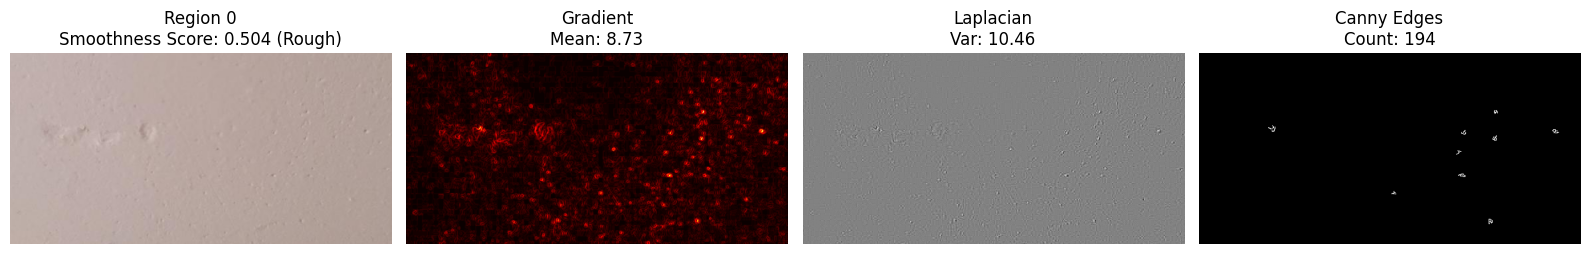

In [100]:
process_and_plot_regions(images[i], target[i])

### Model and optimizer

In [ ]:

device = 'cuda'
model = fasterrcnn_resnet50_fpn(pretrained=True)
# for param in model.parameters():
#     param.requires_grad = False
    
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 3)
model.to(device)

c:\Users\pratyush\miniconda3\envs\fyp\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\pratyush\miniconda3\envs\fyp\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [33]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=1e-4)

In [34]:
for name,param in model.named_parameters():
    if param.requires_grad:
        print(name)


backbone.body.layer2.0.conv1.weight
backbone.body.layer2.0.conv2.weight
backbone.body.layer2.0.conv3.weight
backbone.body.layer2.0.downsample.0.weight
backbone.body.layer2.1.conv1.weight
backbone.body.layer2.1.conv2.weight
backbone.body.layer2.1.conv3.weight
backbone.body.layer2.2.conv1.weight
backbone.body.layer2.2.conv2.weight
backbone.body.layer2.2.conv3.weight
backbone.body.layer2.3.conv1.weight
backbone.body.layer2.3.conv2.weight
backbone.body.layer2.3.conv3.weight
backbone.body.layer3.0.conv1.weight
backbone.body.layer3.0.conv2.weight
backbone.body.layer3.0.conv3.weight
backbone.body.layer3.0.downsample.0.weight
backbone.body.layer3.1.conv1.weight
backbone.body.layer3.1.conv2.weight
backbone.body.layer3.1.conv3.weight
backbone.body.layer3.2.conv1.weight
backbone.body.layer3.2.conv2.weight
backbone.body.layer3.2.conv3.weight
backbone.body.layer3.3.conv1.weight
backbone.body.layer3.3.conv2.weight
backbone.body.layer3.3.conv3.weight
backbone.body.layer3.4.conv1.weight
backbone.body.

### Training Loop

In [35]:
num_epochs = 10
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    model.train()
    train_loss = 0.0

    for images, targets in tqdm(train_dataloader, desc="Training"):
        images = [T.ToTensor()(img).to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        train_loss += losses.item()

    print(f"Train Loss: {train_loss / len(train_dataloader):.4f}")

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, targets in tqdm(val_dataloader, desc="Validation"):
            images = [T.ToTensor()(img).to(device) for img in images]
            outputs = model(images)

            for output, target in zip(outputs, targets):
                pred_labels = output['labels'].cpu()
                true_labels = target['labels']
                n = min(len(pred_labels), len(true_labels))
                correct += (pred_labels[:n] == true_labels[:n]).sum().item()
                total += n

    val_acc = correct / total if total > 0 else 0
    print(f"Validation Accuracy: {val_acc:.4f}")




Epoch 1/10


Training: 100%|██████████| 71/71 [00:51<00:00,  1.39it/s]


Train Loss: 0.2833


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.23it/s]


Validation Accuracy: 0.7857

Epoch 2/10


Training: 100%|██████████| 71/71 [00:55<00:00,  1.28it/s]


Train Loss: 0.2134


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


Validation Accuracy: 0.8571

Epoch 3/10


Training: 100%|██████████| 71/71 [00:59<00:00,  1.19it/s]


Train Loss: 0.1874


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.74it/s]


Validation Accuracy: 0.9464

Epoch 4/10


Training: 100%|██████████| 71/71 [01:01<00:00,  1.15it/s]


Train Loss: 0.1744


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]


Validation Accuracy: 0.9643

Epoch 5/10


Training: 100%|██████████| 71/71 [01:04<00:00,  1.11it/s]


Train Loss: 0.1638


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


Validation Accuracy: 0.9286

Epoch 6/10


Training: 100%|██████████| 71/71 [01:06<00:00,  1.07it/s]


Train Loss: 0.1572


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]


Validation Accuracy: 0.9286

Epoch 7/10


Training: 100%|██████████| 71/71 [01:08<00:00,  1.04it/s]


Train Loss: 0.1389


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]


Validation Accuracy: 0.9107

Epoch 8/10


Training: 100%|██████████| 71/71 [01:09<00:00,  1.02it/s]


Train Loss: 0.1260


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.54it/s]


Validation Accuracy: 0.9643

Epoch 9/10


Training: 100%|██████████| 71/71 [01:10<00:00,  1.01it/s]


Train Loss: 0.1180


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


Validation Accuracy: 0.9643

Epoch 10/10


Training: 100%|██████████| 71/71 [01:11<00:00,  1.00s/it]


Train Loss: 0.1165


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.37it/s]

Validation Accuracy: 0.9464


### Testing + Metric evaluation

→ Pred Label: Smooth, Smoothness Score: 0.937, True Label: Smooth


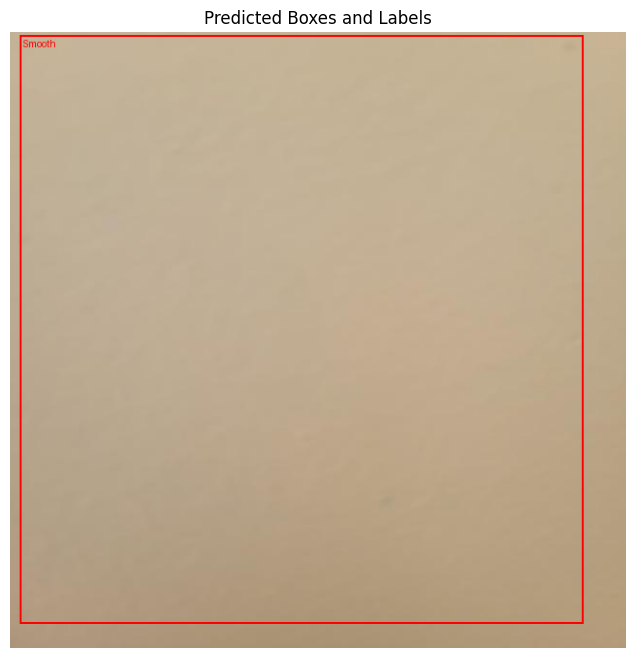

→ Pred Label: Smooth, Smoothness Score: 0.971, True Label: Smooth


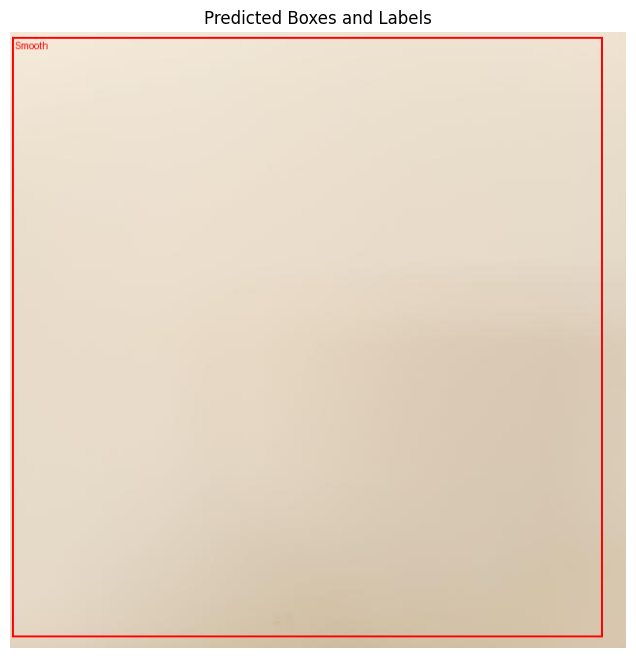

→ Pred Label: Rough, Smoothness Score: 0.269, True Label: Rough


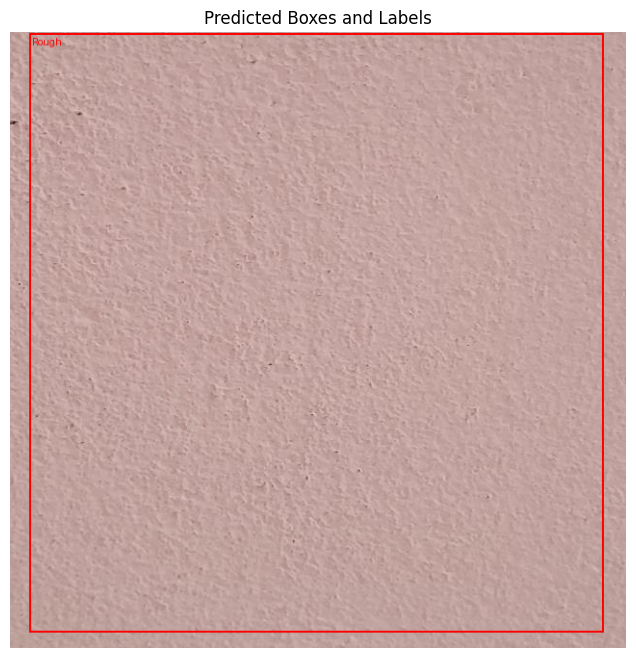

→ Pred Label: Rough, Smoothness Score: 0.255, True Label: Rough


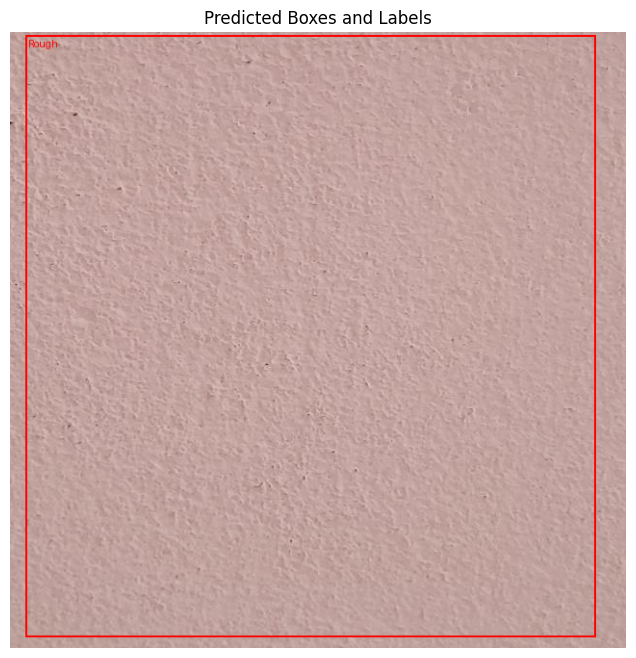

→ Pred Label: Rough, Smoothness Score: 0.426, True Label: Rough
→ Pred Label: Rough, Smoothness Score: 0.396, True Label: Rough


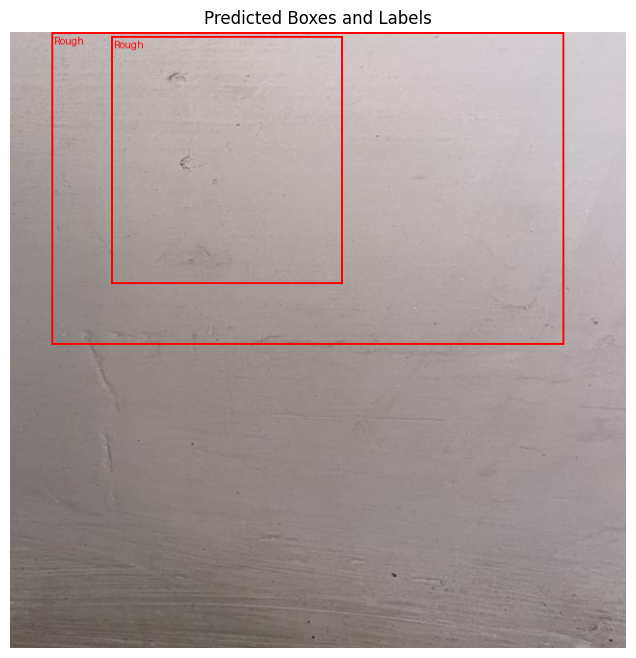

→ Pred Label: Smooth, Smoothness Score: 0.959, True Label: Smooth


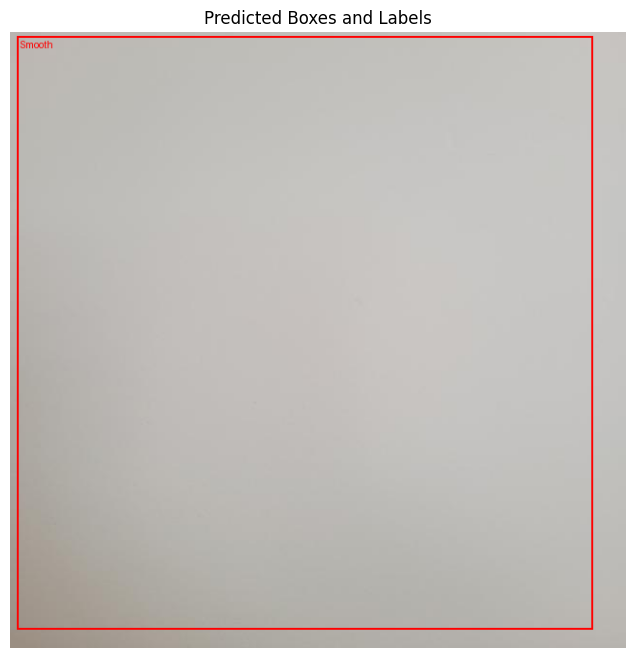

→ Pred Label: Smooth, Smoothness Score: 0.939, True Label: Smooth


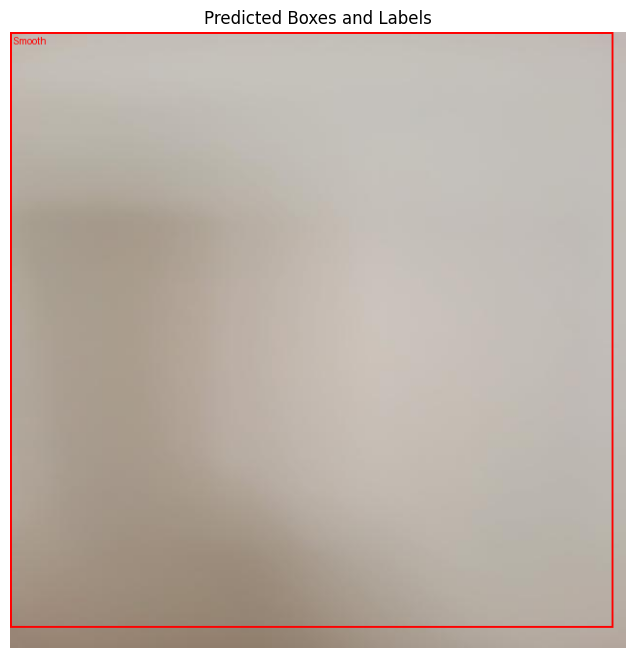

→ Pred Label: Smooth, Smoothness Score: 0.808, True Label: Rough


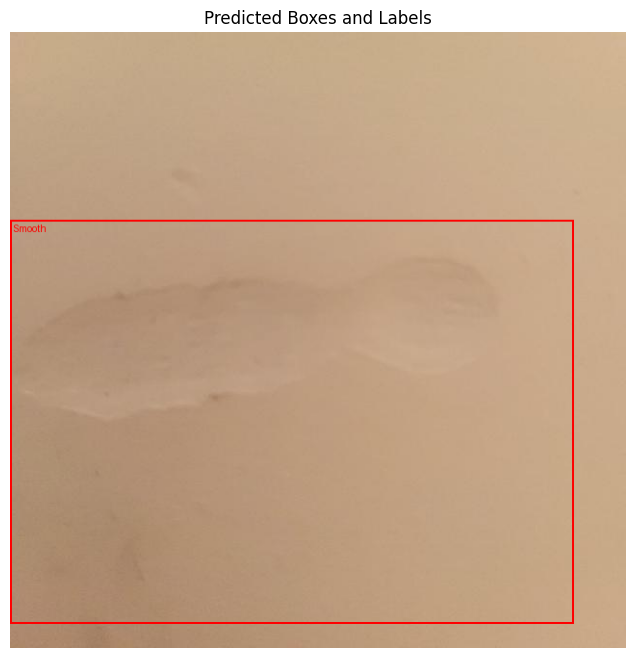

In [ ]:
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

model.eval()  
class_map = {1: "Rough", 2: "Smooth"}

correct = 0
total = 0

n_show = 8
shown = 0

for images, targets in test_dataloader:
    images = [T.ToTensor()(img).to(device) for img in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    with torch.no_grad():
        outputs = model(images)

    for img_tensor, output, target in zip(images, outputs, targets):
      
        scores = output['scores']
        keep = scores > 0.6 

        pred_labels = output['labels'][keep]
        pred_boxes = output['boxes'][keep]
        scores = scores[keep]

        true_labels = target['labels']

        matched = sum([pred == gt for pred, gt in zip(pred_labels, true_labels)])
        correct += matched
        total += len(true_labels)

        if shown < n_show:
            img = (img_tensor * 255).byte().cpu().numpy().transpose(1, 2, 0)
            img_tensor_vis = (img_tensor * 255).byte().cpu()

            for i, (box, label) in enumerate(zip(pred_boxes, pred_labels)):
                x1, y1, x2, y2 = map(int, box.cpu().tolist())
                crop = img[y1:y2, x1:x2]
                if crop.size == 0:
                    continue

                smoothness_score,*_ = wall_surface_smoothness_score(crop)
                print(f"→ Pred Label: {class_map.get(label.item())}, Smoothness Score: {smoothness_score:.3f}, True Label: {class_map[true_labels[i].item()]}")

            drawn = draw_bounding_boxes(img_tensor_vis, pred_boxes.cpu(), 
                                        [class_map.get(l.item(), "Unknown") for l in pred_labels], 
                                        colors="red", width=2, font_size=20)
            plt.figure(figsize=(8, 8))
            plt.imshow(to_pil_image(drawn))
            plt.axis("off")
            plt.title("Predicted Boxes and Labels")
            plt.show()
            shown += 1
